https://sorabatake.jp/11731/

In [4]:
import numpy as np 
import os
import random 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import glob 
import matplotlib.pyplot as plt 
from mymodule import myfunc as mf
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
%matplotlib inline
load_dotenv()
# imgout = os.environ["imgout"]
root_dir = os.environ["root_dir"]

np.random.seed(0) 
 #乱数のシードの設定
DO_PCA = False
ALTIMAGES0 = root_dir+"imgout/MLtest/0/"
ALTIMAGES1 = root_dir+"imgout/MLtest/1/"
def compress(array, LEVEL=1):
    return mf.convolute(array,mf.ave_carnel(LEVEL), stride = LEVEL)
temp = compress(mf.load(mf.gen_snap_path("density",1,1),z=3))
IMGSHAPE = temp.shape
print(IMGSHAPE)
LABEL_SOURCE = "txt/77AVSsplit_labels/2/*"
JUDGE_COLUMN = "is_reconnecting1"###############
labelcsvs = glob.glob(root_dir+LABEL_SOURCE)############
columns = ["path",JUDGE_COLUMN]###############
df = pd.DataFrame(columns=columns)
for labelcsv in labelcsvs:
    dftmp = pd.read_csv(labelcsv, index_col=0)[columns]
    df = pd.concat([df,dftmp])

PATH0 = list(df[df[JUDGE_COLUMN] == 0]["path"])
PATH0 = list(map(lambda path : root_dir+path, PATH0))
PATH1 = list(df[df[JUDGE_COLUMN] == 1]["path"])
PATH1 = list(map(lambda path : root_dir+path, PATH1))
mf.sort_paths
class report:
    """
    ALTIMAGES0
    ALTIMAGES1
    train0 size:
    train1 size:
    all train0 size:
    all train1 size:
    test0 size:
    test1 size:
    IMGSHAPE:
    dataset:??
    LABEL_SOURCE:and JUDGE_COLUMN
    DO_PCA?, PCAscore
    test, pred, approach
        metrics, summary
    note:ex) 水増しの種類、

    func
        create
        read
        add
        delete
    画像のまとめhtml出力
        mf.sort_paths
        偽陽とかだけに絞るとかも
    """
    def size_dir(path):
        return len(glob.glob(path))

result   Y,X: 1025 513
original Y,X: (1025, 513)
(1025, 513)


In [15]:
import glob
def size_dir(path):
    return len(glob.glob(path))

AttributeError: 'int' object has no attribute '__name__'

In [5]:

# PATH0


# テストデータと訓練データを分ける


In [6]:
from sklearn.model_selection import train_test_split
PATH0TRAIN, PATH0TEST = train_test_split(PATH0, test_size=0.6, shuffle=True, random_state=0)
PATH1TRAIN, PATH1TEST = train_test_split(PATH1, test_size=0.6, shuffle=True, random_state=0)



# 水増し

todo jpgのjpgの水増し非対応、読み込み時にIMGSHAPEと対応させる

In [26]:
#リコネクションがない画像ファイルのパスのリストを取得
files = PATH0TRAIN

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES0

#ランダムな領域の切り取りを行う関数
def random_crop(imagearay, size=0.8):
    height, width, _ = imagearay.shape
    crop_size = int(min(height, width) * size)

    top = np.random.randint(0, height - crop_size)
    left = np.random.randint(0, width - crop_size)
    bottom = top + crop_size
    right = left + crop_size
    imagearay = imagearay[top:bottom, left:right,:]
    #motonosaizunimoosu
    return imagearay

def altarray_save(item, temp_output_dir):
    img = mf.load(item, z=3)
    file_name = os.path.basename(item)
    
    img_flip = np.flipud(img) # 画像の上下反転
    np.save(temp_output_dir + "flip_" + file_name , img_flip) # 画像保存
        
    img_mirror = np.fliplr(img) # 画像の左右反転
    np.save(temp_output_dir + "mirr_" + file_name , img_mirror) # 画像保存
            
    img_T = img.T # 画像の上下左右反転
    np.save(temp_output_dir + "trns_" + file_name , img_T) # 画像保存
    
    # img_crop = random_crop(img) # 画像の切り取り
    # img_crop = img_crop.resize((256, 256)) # 元のサイズに戻す
    # img_crop.save(temp_output_dir + file_name + "_crop.png") # 画像保存
 
for item in files:
    
    altarray_save(item,temp_output_dir)

In [27]:
#リコネクションがある画像ファイルのパスのリストを取得
files = PATH1TRAIN

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES1

for item in files:
    altarray_save(item,temp_output_dir)


# 読み込み & regularize

In [12]:
# 訓練データ
ALLTARINDATA0 = glob.glob(ALTIMAGES0+"*") + PATH0TRAIN
ALLTARINDATA1 = glob.glob(ALTIMAGES1+"*") + PATH1TRAIN
num_of_data_clear = len(ALLTARINDATA0) # リコネクションがない画像の枚数
num_of_data_cloudy = len(ALLTARINDATA1) # リコネクションがある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # 学習データの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数
X_train = np.zeros((num_of_data_total, N_col)) # 学習データ格納のためゼロ行列生成
y_train = np.zeros((num_of_data_total)) # 学習データに対するラベルを格納するためのゼロ行列生成
path_train = list("" for i in range(num_of_data_total)) # 学習データに対するpathを格納するためのゼロ行列生成

# リコネクションがない画像を行列に読み込む
path_list = ALLTARINDATA0
i_count = 0

def load_regularize(item):
    type = item[-4:]
    print(item)
    if type == ".npy":
        im = np.load(item)
    elif type == ".npz":
        print("npz doesnot supported")
        return
    elif type == ".jpg":
        im = Image.open(item).convert('L')
        im =im.resize(IMGSHAPE) # 画像のサイズ変更
        im = np.ravel(np.array(im)) # 画像を配列に変換
        # im = im_array/255. # 正規化 
    else:
        im = mf.load(item, z=3)
    # img_resize = compress(im)
    img_resize = im
    return ((img_resize - min(img_resize.flat)) / max(img_resize.flat)).flat # 正規化

for item in path_list:
    X_train[i_count,:] = load_regularize(item)
    y_train[i_count] = 0 # リコネクションがないことを表すラベル
    path_train[i_count] = item
    i_count += 1

  
# リコネクションがある画像を行列に読み込む
path_list = ALLTARINDATA1

for item in path_list:
    X_train[i_count,:] = load_regularize(item)
    y_train[i_count] = 1 # リコネクションがあることを表すラベル
    print("item")
    path_train[i_count] = item
    i_count += 1

C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00387.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00243.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00314.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00338.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00399.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00422.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00349.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00312.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00498.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00298.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00421.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00293.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVS

In [13]:
# テストデータ
num_of_data_clear = len(PATH0TEST) # リコネクションがない画像の枚数
num_of_data_cloudy = len(PATH1TEST) # リコネクションがある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # テストデータの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数(RGBなら*3)
X_test = np.zeros((num_of_data_total, N_col)) # テストデータ格納のためゼロ行列生成
y_test = np.zeros(num_of_data_total) # テストデータに対するラベルを格納するためのゼロ行列生成
path_test = list("" for i in range(num_of_data_total)) # テストデータに対するpathを格納するためのゼロ行列生成

# リコネクションがない画像を行列に読み込む
path_list = PATH0TEST 
i_count = 0
for item in path_list:

    X_test[i_count,:] = load_regularize(item)
    y_test[i_count] = 0 # リコネクションがないことを表すラベル
    path_test[i_count] = item
    i_count += 1

# リコネクションがある画像を行列に読み込む
path_list = PATH1TEST

for item in path_list:
    X_test[i_count,:] = load_regularize(item)
    y_test[i_count] = 1 # リコネクションがあることを表すラベル
    path_test[i_count] = item
    i_count += 1 

C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00425.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00352.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00428.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00401.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00252.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00445.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00375.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00368.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00423.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00417.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00311.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVSsplit2/4/4_img00_00335.jpg
C:/Users/lkxl1/OneDrive/デスクトップ/research/imgout/77AVS

# 学習

# PCA

In [14]:
from sklearn.decomposition import PCA
if DO_PCA:
    N_dim =  100 #100列に落とし込む

    pca = PCA(n_components=N_dim, random_state=0)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))
else:
    X_train_pca = X_train
    X_test_pca = X_test
    print("PCA 非実施")

KeyboardInterrupt: 

# Linear SVC

In [15]:
from sklearn.svm import LinearSVC # ライブラリのインポート

model = LinearSVC(C=0.3, random_state=0) # インスタンスを生成

# model.fit(X_train_pca, y_train) # モデルの学習
model.fit(X_train, y_train) # モデルの学習###########################

# 学習データに対する精度
# print("Train :", model.score(X_train_pca,  y_train)) 
print("Train :", model.score(X_train,  y_train)) #############################

# テストデータに対する精度
# print("Test :", model.score(X_test_pca, y_test)) 
print("Test :", model.score(X_test, y_test)) 
print(model.predict(X_test))

pred = model.predict(X_test)
# svmres = pd.DataFrame(np.array([path_test, y_test, model.predict(X_test_pca)]).T, columns=["path", "y", "predict"])
svmres = pd.DataFrame(np.array([path_test, y_test, pred]).T, columns=["path", "y", "predict"])###################
print(classification_report(y_test, pred))

c:\Users\lkxl1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Train : 1.0
Test : 0.983402489626556
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1.]


AttributeError: module 'pandas' has no attribute 'Dataframe'

# KNeighbors Classifier

In [93]:
from sklearn.neighbors import KNeighborsClassifier # ライブラリのインポート

n_neighbors = int(np.sqrt(6000))  # kの設定

model = KNeighborsClassifier(n_neighbors = n_neighbors)  
model.fit(X_train_pca, y_train) # モデルの学習

# 精度
print("Train :", model.score(X_train_pca, y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 0.963091922005571
Test : 0.9624478442280946


# 非線形SVC RBFカーネル

In [94]:

from sklearn.svm import SVC # ライブラリのインポート

model = SVC(C=0.3, kernel='rbf', random_state=0) # インスタンスを生成 

model.fit(X_train_pca, y_train) # モデルの学習

# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 0.9735376044568245
Test : 0.9726471951784886


# XGBoost

In [80]:
import xgboost as xgb # ライブラリのインポート

model = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3) # インスタンスの生成
           
model.fit(X_train_pca, y_train) # モデルの学習
   
# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 1.0
Test : 0.9935095039406583


# まとめ

In [35]:
from sklearn.model_selection import *
train_sizes = np.array([0.1, 0.33, 0.55, 0.78, 1. ]) # 用いる学習データの割合を全体の0.1〜1まで変化させる

train_sizes, train_scores_linearSVC, test_scores_linearSVC = learning_curve(
    model_linearSVC, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    ) # 様々学習データ数に対して、モデルを学習・評価する。

# 各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_linearSVC = np.mean(train_scores_linearSVC, axis=1)
train_scores_std_linearSVC = np.std(train_scores_linearSVC, axis=1)
validation_scores_mean_linearSVC = np.mean(validation_scores_linearSVC, axis=1)
validation_scores_std_linearSVC = np.std(validation_scores_linearSVC, axis=1)

NameError: name 'model_linearSVC' is not defined

NameError: name 'train_sizes' is not defined

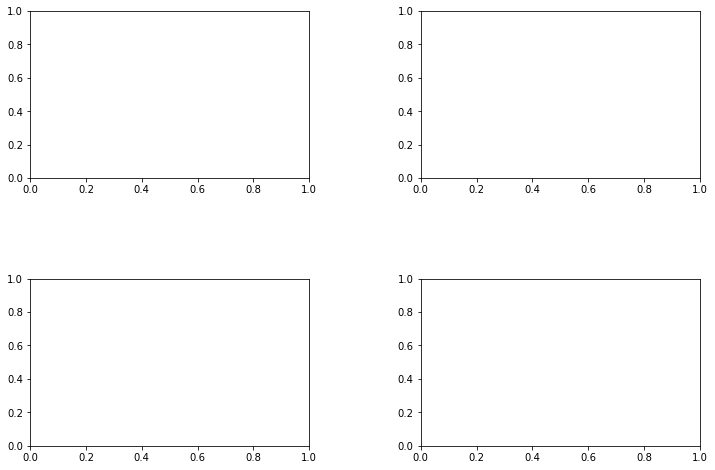

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Linear SVCの学習曲線
ax[0,0].plot(train_sizes, train_scores_mean_linearSVC, 'o-', color="r", label="Training score")
ax[0,0].plot(train_sizes, validation_scores_mean_linearSVC, 'o-', color="g", label="Test score")

ax[0, 0].set_title('Linear SVC')
ax[0, 0].set_xlabel('Number of Taining data')
ax[0, 0].set_ylabel('Accyracy')
ax[0,0].set_ylim(0.4, 0.8)
ax[0,0].legend(loc="best")

# kNNの学習曲線
ax[1,0].plot(train_sizes, train_scores_mean_kNN, 'o-', color="r", label="Training score")
ax[1,0].plot(train_sizes, validation_scores_mean_kNN, 'o-', color="g", label="Test score")

ax[1, 0].set_title('k-NN')
ax[1, 0].set_xlabel('Number of Taining data')
ax[1, 0].set_ylabel('Accuracy')
ax[1,0].set_ylim(0.5, 0.7)
ax[1,0].legend(loc="best")

# 非線形SVCの学習曲線
ax[0,1].plot(train_sizes, train_scores_mean_nonlinearSVC, 'o-', color="r", label="Training score")
ax[0,1].plot(train_sizes, validation_scores_mean_nonlinearSVC, 'o-', color="g", label="Test score")
ax[0, 1].set_title('non-linear SVC')
ax[0, 1].set_xlabel('Number of Taining data')
ax[0, 1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.7, 0.9)
ax[0,1].legend(loc="best")

# XGBoostの学習曲線
ax[1,1].plot(train_sizes, train_scores_mean_xgb, 'o-', color="r", label="Training score")
ax[1,1].plot(train_sizes, validation_scores_mean_xgb, 'o-', color="g", label="Test score")

ax[1, 1].set_title('XGBoost')
ax[1, 1].set_xlabel('Number of Taining data')
ax[1, 1].set_ylabel('Accuracy')
ax[1,1].set_ylim(0.7, 1.0)
ax[1,1].legend(loc="best")
